In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


You are using pip version 18.1, however version 21.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from scipy.cluster.vq import vq, kmeans2
from scipy.spatial.distance import cdist
from PIL import Image
from tensorflow.keras.preprocessing import image as kimage

In [5]:
#Extract Feature function (extract feature by pretrain model)
def extract_feature(base_model, image_path):
  img = cv2.imread(image_path)
  img = cv2.resize(img, (224, 224))
  feature_extractor = base_model.predict(img.reshape(1, 224, 224, 3))
  return feature_extractor


In [6]:
def compute_code_books(vectors, sub_size=2, n_cluster=128, n_iter=20, minit='points', seed=123):
    n_rows, n_cols = vectors.shape
    n_sub_cols = n_cols // sub_size

    np.random.seed(seed)
    code_books = np.zeros((sub_size, n_cluster, n_sub_cols), dtype=np.float32)
    for subspace in range(sub_size):
        sub_vectors = vectors[:, subspace * n_sub_cols:(subspace + 1) * n_sub_cols]
        centroid, label = kmeans2(sub_vectors, n_cluster, n_iter, minit=minit)
        code_books[subspace] = centroid

    return code_books

In [7]:
def encode(vectors, code_books):
    n_rows, n_cols = vectors.shape
    sub_size = code_books.shape[0]
    n_sub_cols = n_cols // sub_size

    codes = np.zeros((n_rows, sub_size), dtype=np.int32)
    for subspace in range(sub_size):
        sub_vectors = vectors[:, subspace * n_sub_cols:(subspace + 1) * n_sub_cols]
        code, dist = vq(sub_vectors, code_books[subspace])
        codes[:, subspace] = code

    return codes

In [8]:
def query_dist_table(query, code_books):
    sub_size, n_cluster, n_sub_cols = code_books.shape

    dist_table = np.zeros((sub_size, n_cluster))
    for subspace in range(sub_size):
        sub_query = query[subspace * n_sub_cols:(subspace + 1) * n_sub_cols]

        diff = code_books[subspace] - sub_query.reshape(1, -1)
        diff = np.sum(diff ** 2, axis=1)
        dist_table[subspace, :] = diff

    return dist_table

#Backbone is ResNet50


In [44]:
resnet50 = keras.applications.resnet.ResNet50(weights="weight_resnet50.h5", include_top=False, input_shape=(224, 224, 3))
output = keras.layers.Flatten()(resnet50.output)

In [45]:
basemodel = Model(inputs = resnet50.input, outputs=output)

#Read Query Image & Extract Feature

In [46]:
#initializtion 
query_path = "D:\image_retrieval_server\image_retrieval\query_pic\q (3).png"
#extract feature
query_feature = extract_feature(basemodel, query_path).flatten()
#check
print(query_feature.shape)

(100352,)


(dtype('uint8'), (224, 224, 3))

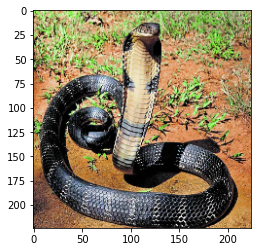

In [47]:
img = cv2.imread(query_path)
img = cv2.resize(img, (224, 224))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img.dtype, img.shape

In [25]:
def folder_to_images(folder):
    
    list_dir = [folder + '/' + name for name in os.listdir(folder) if name.endswith((".jpg", ".png", ".jpeg"))]
    
    i = 0
    images_np = np.zeros(shape=(len(list_dir), 224, 224, 3))
    images_path = []
    for path in list_dir:
        try:
            img = kimage.load_img(path, target_size=(224, 224))
            images_np[i] = kimage.img_to_array(img, dtype=np.float32)
            images_path.append(path)
            i += 1
            
        except Exception:
            print("error: ", path)
    #         os.remove(root_img_path + img_path)

    images_path = np.array(images_path)
    return images_np, images_path

In [27]:
root_img_path = "D:/image_retrieval_server/image_retrieval/static/img/"
root_fearure_path = "D:/image_retrieval_server/image_retrieval/static/feature/file1/"
dic_categories = ['scenery', 'furniture', 'animal', 'plant']
ls_path_score = []
images_feature=[]
images_path=[]
for folder in os.listdir(root_img_path):
  if folder.split("_")[0] in dic_categories:
    path = root_img_path + folder
    
    for file in os.listdir(path):
      if (file.endswith((".jpg", ".png", ".jpeg"))):
        image_path = path + '/' + file
        images_feature.append(extract_feature(basemodel, image_path))
        images_path.append(image_path)

In [34]:
images_feature = np.asarray(images_feature)
images_path = np.asarray(images_path)

In [36]:
images_feature = images_feature.reshape((images_feature.shape[0],images_feature.shape[2]))
images_feature.shape

(17066, 100352)

In [37]:
images_path.shape

(17066,)

In [38]:
np.savez_compressed(root_fearure_path+"all_feartures", array1=np.array(images_path), array2=np.array(images_feature))

In [39]:
data = np.load("D:/image_retrieval_server/image_retrieval/static/feature/file1/all_feartures.npz")
paths_feature = data["array1"]
imgs_feature = data["array2"]

In [40]:
paths_feature.shape

(17066,)

In [41]:
imgs_feature.shape

(17066, 100352)

In [16]:
images_path.shape

(17066,)

In [43]:
M = 256  # M sub-vector
codebooks = compute_code_books(imgs_feature, M, 256) 
pqcode = encode(imgs_feature, codebooks) 
dist_table = query_dist_table(query_feature, codebooks)

d:\[CODE] image_retrieval\env\lib\site-packages\scipy\cluster\vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [48]:
# lookup the distance
dists = np.sum(dist_table[range(M), pqcode], axis=1)
# the numpy indexing trick is equivalent to the following loop approach
n_rows = pqcode.shape[0]
dists = np.zeros(n_rows).astype(np.float32)
for n in range(n_rows):
    for m in range(M):
        dists[n] += dist_table[m][pqcode[n][m]]


In [49]:
# find the nearest neighbors and "translate" it to the original labels
k = 30
nearest = np.argsort(dists)[:k]
nearest

array([6163, 6223, 6217, 6236, 6218, 6232, 6209, 6243, 6158, 6196, 6256,
       6248, 6165, 6185, 6200, 6231, 6211, 6260, 1798, 6173, 6252, 6229,
       6219, 6162, 6245, 6205, 6253, 2119, 6250, 6259], dtype=int64)

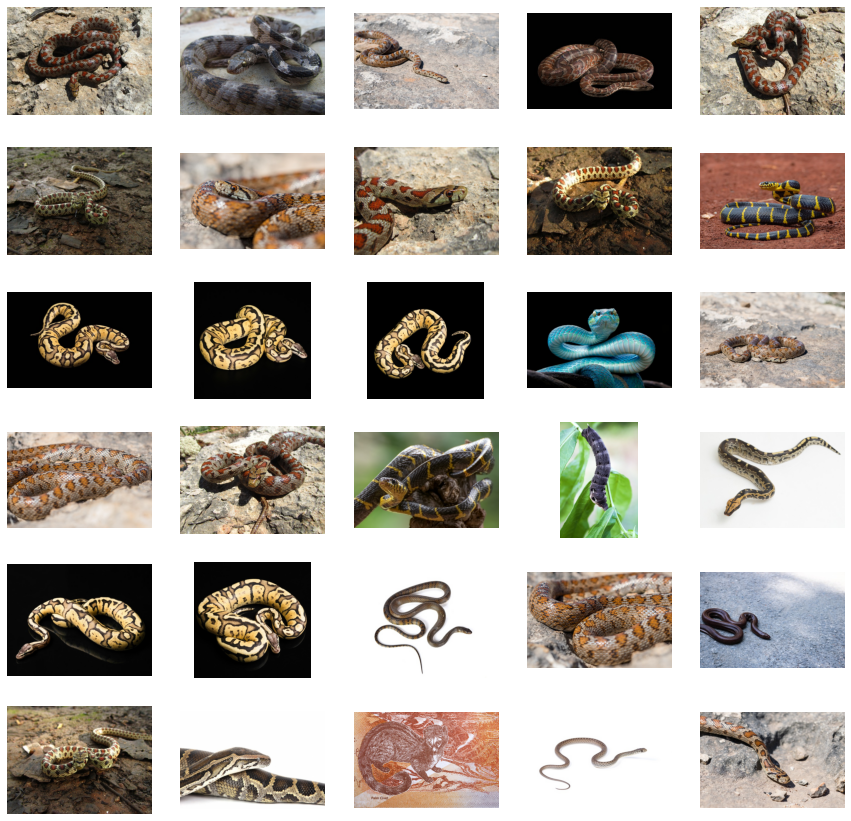

In [50]:
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 6
for i, path in enumerate(nearest, 1):
  img = np.random.randint(10, size=(10,10))
  fig.add_subplot(rows, columns, i)
  plt.imshow(plt.imread(paths_feature[path]))
  plt.axis("off")
plt.show()